In [5]:
import os
import sys

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import sktime   # https://www.sktime.org/en/stable/users.html
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import DistanceMetric
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")

sns.set()
plt.style.use('bmh')

import json

In [6]:
with open(r'acn.json', 'r') as jf:
    ev = json.load(jf)
       
# Flatten data
df = pd.json_normalize(ev, record_path =['_items'])
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None


In [7]:
#Initial Data Preprocessing Steps
df_pre=df
def date_conversion(col):     
    date_connection_time = pd.to_datetime(df_pre[col], format="%a, %d %b %Y %X %Z")
    date_format_connect = date_connection_time.dt.tz_localize(None)
    connect_date = date_format_connect.dt.date
    df_pre[col] = connect_date
    df_pre[col]=df_pre[col].astype('datetime64[ns]')
df_pre['doneChargingTime'].fillna(df_pre['disconnectTime'],inplace=True) # Fill Null values
date_conversion('connectionTime')
date_conversion('disconnectTime')
date_conversion('doneChargingTime')
def ev_univ(input_col,pred_col):
    ev_univ = df_pre[[input_col,pred_col]]
    ev_univ_agg = ev_univ.groupby([input_col]).agg({pred_col:np.sum})
    return ev_univ_agg
uni_done = ev_univ('doneChargingTime','kWhDelivered')
uni_conn = ev_univ('connectionTime','kWhDelivered')
uni_disconn = ev_univ('disconnectTime','kWhDelivered')
uni_2=uni_disconn.reset_index()
df_1=uni_2
df_1

,disconnectTime,kWhDelivered
0,2018-04-25,151.103
1,2018-04-26,385.389
2,2018-04-27,409.963
3,2018-04-28,540.545
4,2018-04-29,267.643
...,...,...
1074,2021-09-10,393.768
1075,2021-09-11,315.598
1076,2021-09-12,179.279
1077,2021-09-13,368.374


In [8]:
#Importing Date Lookup table
      
# Flatten data
date_df = pd.read_csv(r'date_lookup.csv')
date_df.head()

,Date,Year,Month,Day
0,25-Apr-2018,2018,4,25
1,26-Apr-2018,2018,4,26
2,27-Apr-2018,2018,4,27
3,28-Apr-2018,2018,4,28
4,29-Apr-2018,2018,4,29


In [9]:
#Lookup Table processing
date_df['Date'] = date_df['Date'].astype('datetime64')
date_df.set_index('Date')
merge=pd.merge(date_df,df_1, how='left',left_on='Date',right_on='disconnectTime')
merge['day_of_week'] = merge['Date'].dt.weekday
merge["IsWeekend"] = merge["day_of_week"] >= 5
analy = merge[['Date','kWhDelivered']]
analy_weekend = merge[['Date','IsWeekend','kWhDelivered']]
analy_1=analy.set_index('Date')
analy_weekend_1=analy_weekend.set_index('Date')
#KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df = pd.DataFrame(imputer.fit_transform(analy_weekend_1),columns = analy_weekend_1.columns)
#Concatenating date lookup and source data
x1=pd.concat([analy_weekend,df], axis=1, ignore_index=True)
final=x1
final.drop(3,axis=1,inplace=True)
final.drop(2,axis=1,inplace=True)
final_df=final.rename(columns={0:'Date',1: "IsWeekend", 4: "kWhDelivered"})
uni_3=final_df
uni_3=uni_3.set_index('Date')
uni_3.index.freq = 'D'
uni_3_filter=uni_3['kWhDelivered']
uni_3.rename(columns={'kWhDelivered':'Kwh'},inplace=True)
uni_3_filter = uni_3
uni_3_filter = uni_3_filter.drop('IsWeekend',axis=1,inplace=True)
data=uni_3 # Data for forecastinng

In [10]:
data

,Kwh
Date,
2018-04-25,151.103
2018-04-26,385.389
2018-04-27,409.963
2018-04-28,540.545
2018-04-29,267.643
...,...
2021-09-10,393.768
2021-09-11,315.598
2021-09-12,179.279


In [11]:
data.describe()

,Kwh
count,1239.000000
mean,260.748749
std,202.854358
min,0.591000
25%,115.390500
50%,221.027400
75%,353.267006
max,1000.640991


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2018-04-25 to 2021-09-14
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Kwh     1239 non-null   float64
dtypes: float64(1)
memory usage: 19.4 KB


In [28]:
my_series = data.squeeze()

In [29]:
my_series

Date
2018-04-25    151.103
2018-04-26    385.389
2018-04-27    409.963
2018-04-28    540.545
2018-04-29    267.643
               ...   
2021-09-10    393.768
2021-09-11    315.598
2021-09-12    179.279
2021-09-13    368.374
2021-09-14    257.535
Freq: D, Name: Kwh, Length: 1239, dtype: float64

In [54]:
# test_len = int(len(data) * 0.2)
data_train, data_test = my_series.iloc[:1224], my_series.iloc[1224:]

In [60]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)
    mse = mean_squared_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}, MSE:{mse:.3f}", size=18)
#     series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape, mse

In [61]:
def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster

In [62]:
def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape,mse = plot_forecast(train, test, y_pred)

    return mae, mape, mse


best params: {'window_length': 15}


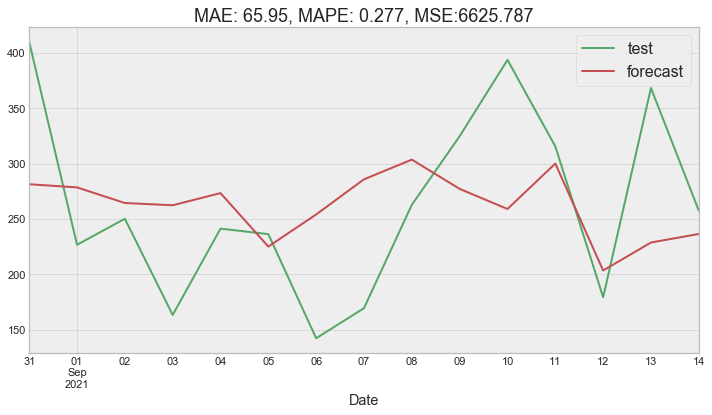

In [63]:
# param_grid = {
#     "window_length": [5, 10, 15, 20, 25, 30] # parameter set to be grid searched
# }

param_grid = {
    "window_length": [15]
}
forecaster = create_forecaster()
data_lgb_mae, data_lgb_mape, data_lgb_mse = grid_serch_forecaster(
    data_train, data_test, forecaster, param_grid
)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb=sqrt(mean_squared_error(pred_xgb,y_test))

In [ ]:
print('Mean Squared Error for XGBoost Model is:',rmse_xgb)

In [64]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [65]:
def create_forecaster_w_desesonalizer(sp=7, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=7, strategy="recursive"),
            ),
        ]
    )

    return forecaster

best params: {'forecast__window_length': 42}


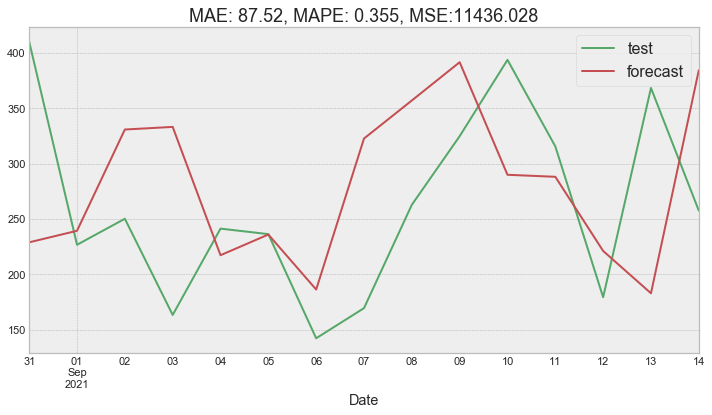

In [66]:
forecaster_s = create_forecaster_w_desesonalizer()
param_grid_s = {"forecast__window_length": [7, 14, 21, 28, 35, 42]}

data_s_lgb_mae, data_s_lgb_mape,data_s_lgb_mse = grid_serch_forecaster(
    data_train, data_test, forecaster_s, param_grid_s
)